In [16]:
import os
import cv2
import numpy as np
from keras.models import Sequential
from keras.layers import Dropout, Conv2D, Flatten, Dense, MaxPooling2D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping 
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score


In [17]:
# Load your custom dataset and labels
# Set the path to the root dataset directory
root_dir = 'dataset/'

# Initialize lists to store images and labels
images = []
labels = []

# Recursively traverse the directory tree
for dirpath, dirnames, filenames in os.walk(root_dir):
    # Loop through the files in the current directory
    for file in filenames:
        if file.endswith('.png'):  # assuming all images are in png format
            image = cv2.imread(os.path.join(dirpath, file))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # convert to grayscale
            image = cv2.resize(image, (24, 24))  # resize to match your model's input shape
            images.append(image)

            # Extract the label from the file name
            if file[16] == '1':
                label = 1
            else:
                label = 0
            labels.append(label)

# Convert the lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Reshape the images for the Conv2D layer
images = images.reshape(images.shape[0], 24, 24, 1)

# Normalize the pixel values between 0 and 1
images = images / 255.0

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [18]:
# Convert the labels to categorical format (one-hot encoding)
y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)

# Create the model
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(24, 24, 1)),
    MaxPooling2D(pool_size=(1, 1)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(1, 1)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(1, 1)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [19]:
# Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

# Model training with Early Stopping
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=32, callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print('Test loss:', loss)
print('Test accuracy:', accuracy)


# Make predictions on the test set
y_pred = model.predict(X_test)

# Convert the predicted probabilities to binary class labels
y_pred_binary = np.argmax(y_pred, axis=1)
y_test_binary = np.argmax(y_test, axis=1)

# Calculate precision, recall, and F1 score
precision = precision_score(y_test_binary, y_pred_binary)
recall = recall_score(y_test_binary, y_pred_binary)
f1 = f1_score(y_test_binary, y_pred_binary)

print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

# Save the model
model.save('models/cnnCat2_custom.h5', overwrite=True)

Epoch 1/15
2123/2123 [==============================] - 270s 127ms/step - loss: 0.1372 - accuracy: 0.9490 - val_loss: 0.0708 - val_accuracy: 0.9723
Epoch 2/15
2123/2123 [==============================] - 277s 130ms/step - loss: 0.0709 - accuracy: 0.9748 - val_loss: 0.0555 - val_accuracy: 0.9797
Epoch 3/15
2123/2123 [==============================] - 291s 137ms/step - loss: 0.0559 - accuracy: 0.9805 - val_loss: 0.0501 - val_accuracy: 0.9819
Epoch 4/15
2123/2123 [==============================] - 296s 139ms/step - loss: 0.0460 - accuracy: 0.9837 - val_loss: 0.0407 - val_accuracy: 0.9856
Epoch 5/15
2123/2123 [==============================] - 289s 136ms/step - loss: 0.0415 - accuracy: 0.9857 - val_loss: 0.0446 - val_accuracy: 0.9841
Epoch 6/15
2123/2123 [==============================] - 287s 135ms/step - loss: 0.0371 - accuracy: 0.9869 - val_loss: 0.0373 - val_accuracy: 0.9873
Epoch 7/15
2123/2123 [==============================] - 288s 136ms/step - loss: 0.0340 - accuracy: 0.9878 - val_

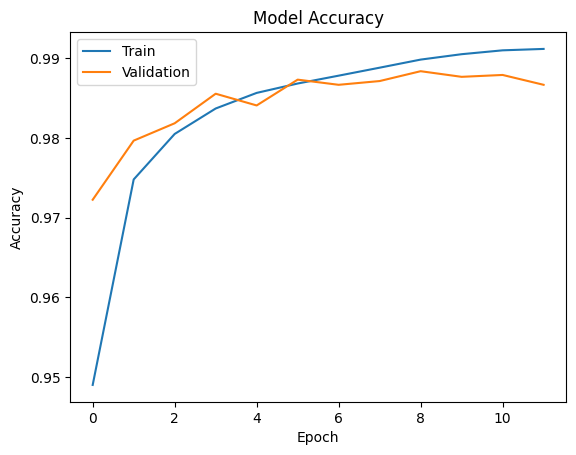

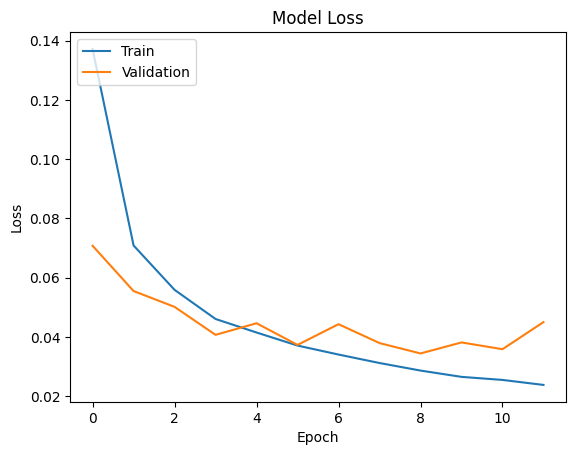

In [20]:
# Plot the accuracy and loss curves
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()